In [113]:
# Cell 1 - Title (renders Markdown)
# Ensure IPython is installed in the environment so the import can be resolved by the linter/runtime
%pip install ipython --quiet

from IPython.display import Markdown, display
display(Markdown("# Philippine Temperature Analysis (2010–Present) — Exploratory Data Analysis (EDA)\n\n"
                 "This notebook performs EDA on the cleaned temperature dataset produced by `01_data_ingest_cleaning.ipynb`. "
                 "We will explore distributions, seasonal patterns, extremes, correlations, and geospatial summaries."))


Note: you may need to restart the kernel to use updated packages.


# Philippine Temperature Analysis (2010–Present) — Exploratory Data Analysis (EDA)

This notebook performs EDA on the cleaned temperature dataset produced by `01_data_ingest_cleaning.ipynb`. We will explore distributions, seasonal patterns, extremes, correlations, and geospatial summaries.

In [114]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
import matplotlib.dates as mdates
from scipy import stats


try:
    import plotly.express as px
    PLOTLY_AVAILABLE = True
except Exception:
    PLOTLY_AVAILABLE = False

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', '{:.3f}'.format)

display(Markdown("## Environment\n- pandas, numpy, matplotlib, seaborn\n- plotly for interactivity if available"))

## Environment
- pandas, numpy, matplotlib, seaborn
- plotly for interactivity if available

In [115]:
def safe_to_numeric(df, cols):
    """Convert specified cols to numeric (coerce errors) and return df."""
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def resample_daily_mean(series):
    """Resample an indexed series to daily mean and return series with datetime index."""
    return series.resample("D").mean()

def plot_gap_aware_time_series(df_times, value_col, gap_days=15, color="crimson", label=None, smooth=True):
    """
    Plot df_times with datetime index and value_col. Break lines when gap > gap_days.
    If smooth and segment long >=4, use cubic spline smoothing.
    """
    from scipy.interpolate import make_interp_spline
    df = df_times[[value_col]].copy().dropna()
    if df.empty:
        return
    df = df.sort_index()
    df = df.reset_index().rename(columns={"index":"datetime"}) if not isinstance(df.index, pd.DatetimeIndex) else df.reset_index()
    df['gap'] = df['datetime'].diff().dt.days.fillna(1)
    df['segment'] = (df['gap'] > gap_days).cumsum()
    for _, seg in df.groupby('segment'):
        if len(seg) == 0:
            continue
        x = seg['datetime']
        y = seg[value_col]
        if smooth and len(seg) >= 4:
            x_num = mdates.date2num(x)
            x_smooth = np.linspace(x_num.min(), x_num.max(), 400)
            spline = make_interp_spline(x_num, y, k=3)
            y_smooth = spline(x_smooth)
            plt.plot(mdates.num2date(x_smooth), y_smooth, color=color, linewidth=1.8, label=label)
        else:
            plt.plot(x, y, color=color, linewidth=1.4, label=label)

def df_head_table(df, n=5):
    display(Markdown(f"**DataFrame preview ({n} rows)**"))
    display(df.head(n))

In [116]:
display(Markdown("## Load cleaned data\nLoad `data/processed/phil_temp_2010_2024.csv` created by the ingestion notebook."))
DATA_PATH = "../data/processed/phil_temp_2010_2024.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Cleaned dataset not found at {DATA_PATH}. Please run 01_data_ingest_cleaning.ipynb and place the output there.")

## Load cleaned data
Load `data/processed/phil_temp_2010_2024.csv` created by the ingestion notebook.

In [117]:
df = pd.read_csv(DATA_PATH)
# Ensure datetime and consistent dtypes
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
# Convert common numeric columns safely
numeric_cols = ['temperature_2m_mean','temperature_2m_max','temperature_2m_min',
                'apparent_temperature_max','apparent_temperature_min']
df = safe_to_numeric(df, numeric_cols)

In [118]:
display(Markdown(f"Loaded dataset: `{DATA_PATH}` — **shape:** {df.shape}"))
df_head_table(df, n=5)
display(Markdown("### Column names and data types"))
display(df.dtypes)
display(Markdown("### Basic statistics (numeric columns)"))
display(df.describe().T)
display(Markdown("### Missing values per column"))
display(df.isnull().sum())

Loaded dataset: `../data/processed/phil_temp_2010_2024.csv` — **shape:** (552212, 7)

**DataFrame preview (5 rows)**

,city_name,datetime,temperature_2m_mean,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min
0,Alaminos,2010-01-01,26.600,29.900,24.800,32.000,26.500
1,Alaminos,2010-01-02,26.700,29.400,25.000,32.100,27.400
2,Alaminos,2010-01-03,26.000,27.600,24.500,30.900,28.600
3,Alaminos,2010-01-04,25.900,28.800,23.100,33.600,27.500
4,Alaminos,2010-01-05,26.400,28.500,24.500,33.700,28.800


### Column names and data types

city_name                           object
datetime                    datetime64[ns]
temperature_2m_mean                float64
temperature_2m_max                 float64
temperature_2m_min                 float64
apparent_temperature_max           float64
apparent_temperature_min           float64
dtype: object

### Basic statistics (numeric columns)

,count,mean,min,25%,50%,75%,max,std
datetime,552212,2015-12-08 08:01:05.127789824,2010-01-01 00:00:00,2012-10-04 00:00:00,2015-07-09 00:00:00,2018-04-12 00:00:00,2024-12-31 22:10:14,NaN
temperature_2m_mean,552212.000,26.477,11.900,25.700,26.600,27.500,34.140,1.774
temperature_2m_max,552212.000,29.116,12.890,27.900,29.200,30.500,39.200,2.357
temperature_2m_min,552212.000,24.454,7.200,23.700,24.700,25.500,34.140,1.916
apparent_temperature_max,500324.000,34.588,13.200,32.600,34.900,36.900,46.100,3.271
apparent_temperature_min,500324.000,28.445,4.900,27.200,29.000,30.300,35.000,2.731


### Missing values per column

city_name                       0
datetime                        0
temperature_2m_mean             0
temperature_2m_max              0
temperature_2m_min              0
apparent_temperature_max    51888
apparent_temperature_min    51888
dtype: int64

In [119]:
display(Markdown("## Missing values handling\nWe'll examine missingness and apply conservative handling:"))
missing_pct = (df.isnull().sum() / len(df) * 100).round(3)
display(missing_pct.sort_values(ascending=False).to_frame("missing_%"))

core_missing = df['temperature_2m_mean'].isnull().sum()
display(Markdown(f"- Core column `temperature_2m_mean` missing rows: **{core_missing}**"))

## Missing values handling
We'll examine missingness and apply conservative handling:

,missing_%
apparent_temperature_max,9.396
apparent_temperature_min,9.396
city_name,0.000
datetime,0.000
temperature_2m_mean,0.000
temperature_2m_max,0.000
temperature_2m_min,0.000


- Core column `temperature_2m_mean` missing rows: **0**

In [120]:
display(Markdown("## Summary statistics — overall"))
summary_vars = [c for c in numeric_cols if c in df.columns]
overall = df[summary_vars].agg(['mean','median','min','max','std']).T
display(overall)

display(Markdown(
    "Interpretation:\n"
    "- `mean` provides central tendency; `std` shows variability across the full time span.\n"
    "- Compare `temperature_2m_max` vs `temperature_2m_min` to see daily amplitude.\n"
    "- Apparent temps (if available) help understand the perceived heat vs measured air temperature."
))

## Summary statistics — overall

,mean,median,min,max,std
temperature_2m_mean,26.477,26.600,11.900,34.140,1.774
temperature_2m_max,29.116,29.200,12.890,39.200,2.357
temperature_2m_min,24.454,24.700,7.200,34.140,1.916
apparent_temperature_max,34.588,34.900,13.200,46.100,3.271
apparent_temperature_min,28.445,29.000,4.900,35.000,2.731


Interpretation:
- `mean` provides central tendency; `std` shows variability across the full time span.
- Compare `temperature_2m_max` vs `temperature_2m_min` to see daily amplitude.
- Apparent temps (if available) help understand the perceived heat vs measured air temperature.

In [121]:
display(Markdown("## Summary statistics — per city"))
city_stats = df.groupby('city_name')[summary_vars].agg(['mean','min','max','std']).sort_values(('temperature_2m_mean','mean'), ascending=False)
display(city_stats.head(10))
display(Markdown("Interpretation: investigate cities with high mean and high std — they have higher average temps and variability."))

## Summary statistics — per city

temperature_2m_mean                     temperature_2m_max  \
                              mean    min    max   std               mean   
city_name                                                                   
Dapitan                     28.075 23.200 32.700 1.296             31.231   
Lapu-Lapu City              28.066 23.200 32.700 1.302             31.228   
Mandaue City                28.028 23.100 32.700 1.308             31.175   
Cebu City                   27.842 23.000 32.500 1.307             31.024   
Taguig                      27.828 22.400 32.500 1.507             30.623   
Bacoor                      27.805 22.400 32.500 1.493             30.603   
Cavite City                 27.785 22.400 32.500 1.451             30.198   
El Salvador                 27.776 22.200 32.200 1.179             30.182   
Las Piñas                   27.738 22.300 32.500 1.494             30.536   
Paranaque City              27.719 22.300 32.400 1.507             30.524   

                                   temperature_2m_min                      \
                  min    max   std               mean    min    max   std   
city_name                                                                   
Dapitan        24.610 38.900 2.391             25.575 21.000 32.030 1.170   
Lapu-Lapu City 24.210 38.900 2.398             25.573 21.000 32.020 1.172   
Mandaue City   23.790 38.800 2.406             25.519 20.900 31.980 1.169   
Cebu City      23.800 38.700 2.407             25.368 20.800 30.810 1.170   
Taguig         23.700 37.100 2.225             25.659 19.600 31.730 1.385   
Bacoor         23.700 37.100 2.199             25.669 19.800 31.730 1.329   
Cavite City    23.700 37.100 2.242             25.912 19.800 31.740 1.231   
El Salvador    22.200 34.500 1.857             25.663 19.700 32.200 1.178   
Las Piñas      23.600 37.000 2.210             25.610 19.800 31.660 1.326   
Paranaque City 23.600 37.000 2.224             25.558 19.500 31.630 1.384   

               apparent_temperature_max                      \
                                   mean    min    max   std   
city_name                                                     
Dapitan                          38.040 26.000 46.100 3.266   
Lapu-Lapu City                   38.028 25.900 46.100 3.266   
Mandaue City                     37.975 25.900 46.000 3.264   
Cebu City                        37.660 25.600 45.700 3.259   
Taguig                           35.645 23.700 43.800 3.218   
Bacoor                           35.574 23.700 43.800 3.267   
Cavite City                      35.227 23.700 43.800 3.321   
El Salvador                      37.543 26.600 43.300 2.294   
Las Piñas                        35.480 23.600 43.700 3.265   
Paranaque City                   35.479 23.600 43.600 3.215   

               apparent_temperature_min                      
                                   mean    min    max   std  
city_name                                                    
Dapitan                          30.203 19.200 33.900 1.572  
Lapu-Lapu City                   30.193 19.200 33.800 1.572  
Mandaue City                     30.141 19.200 33.800 1.571  
Cebu City                        29.835 18.900 33.500 1.567  
Taguig                           29.932 20.500 35.000 2.218  
Bacoor                           29.829 20.500 35.000 2.220  
Cavite City                      29.885 20.500 35.000 2.200  
El Salvador                      30.933 21.300 34.800 1.530  
Las Piñas                        29.736 20.400 34.900 2.217  
Paranaque City                   29.767 20.400 34.800 2.214

Interpretation: investigate cities with high mean and high std — they have higher average temps and variability.

## Time Series — National daily average (gap-aware, smoothed)

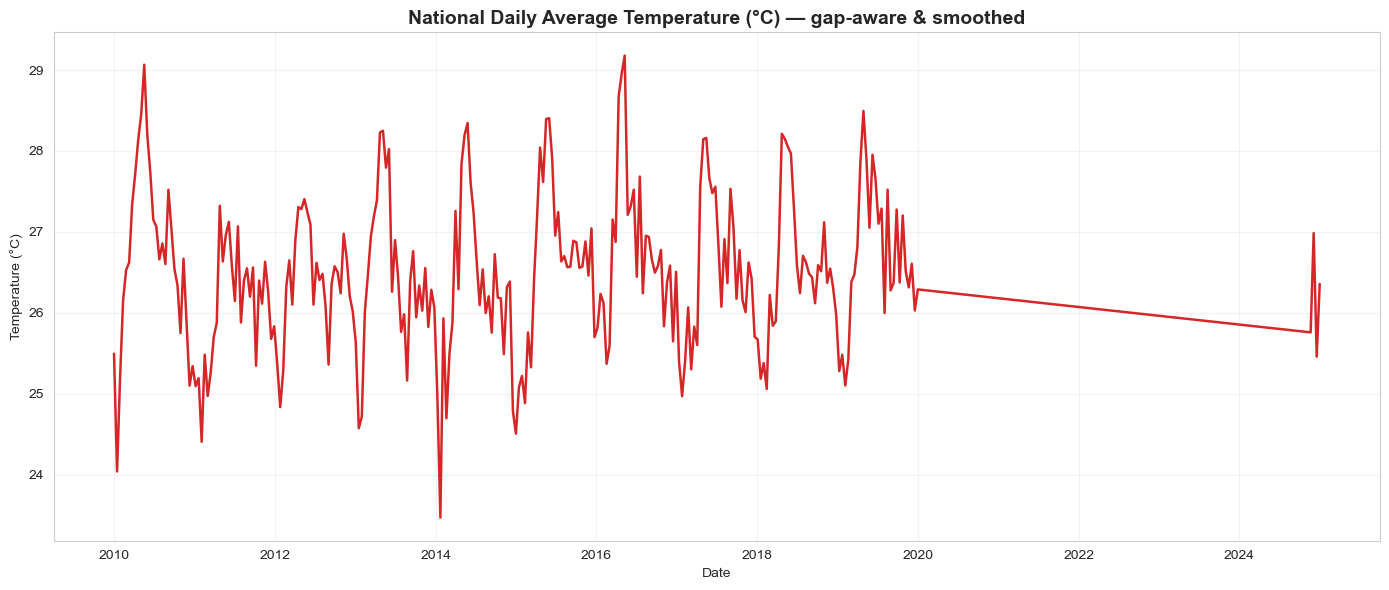

In [122]:
display(Markdown("## Time Series — National daily average (gap-aware, smoothed)"))
df_national = df.set_index('datetime').sort_index()
national_daily = df_national['temperature_2m_mean'].resample('D').mean().interpolate(method='time')

plt.figure(figsize=(14,6))
plot_gap_aware_time_series(national_daily.to_frame(), 'temperature_2m_mean', gap_days=15, color='tab:red', smooth=True)
plt.title("National Daily Average Temperature (°C) — gap-aware & smoothed", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

## Time Series — Top cities (gap-aware & smooth)
Select top cities by number of observations.

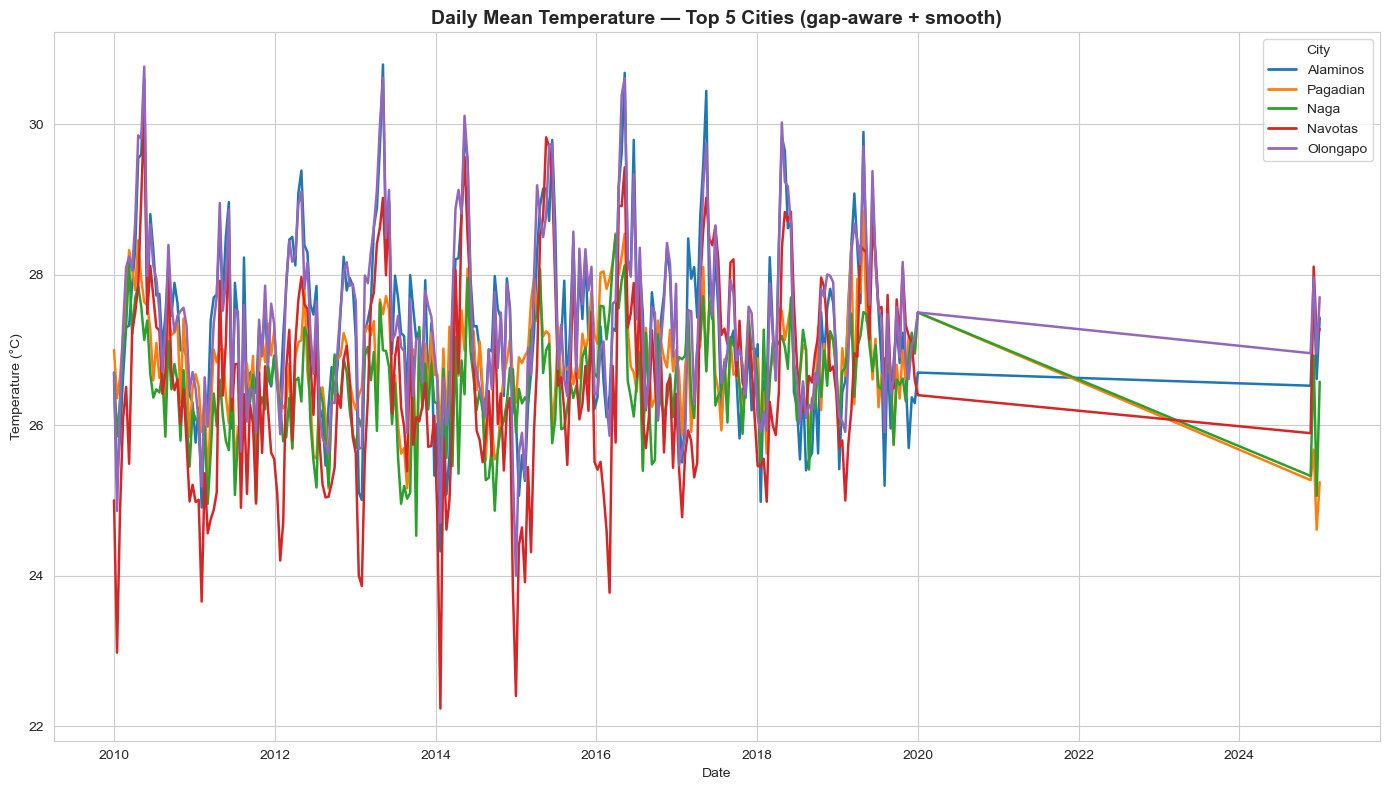

In [123]:
display(Markdown("## Time Series — Top cities (gap-aware & smooth)\nSelect top cities by number of observations."))

top_n = 5
top_cities = df['city_name'].value_counts().nlargest(top_n).index.tolist()
colors = sns.color_palette("tab10", n_colors=len(top_cities))

plt.figure(figsize=(14,8))
for i, city in enumerate(top_cities):
    city_df = df[df['city_name'] == city].set_index('datetime').sort_index()
    city_daily = city_df['temperature_2m_mean'].resample('D').mean().interpolate(method='time')
    plot_gap_aware_time_series(city_daily.to_frame(), 'temperature_2m_mean', gap_days=15, color=colors[i], smooth=True, label=None)
    
for i, city in enumerate(top_cities):
    plt.plot([], [], color=colors[i], label=city, linewidth=2.0)
plt.legend(title="City")
plt.title(f"Daily Mean Temperature — Top {top_n} Cities (gap-aware + smooth)", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()


## Rolling averages (3-month & 12-month) — National

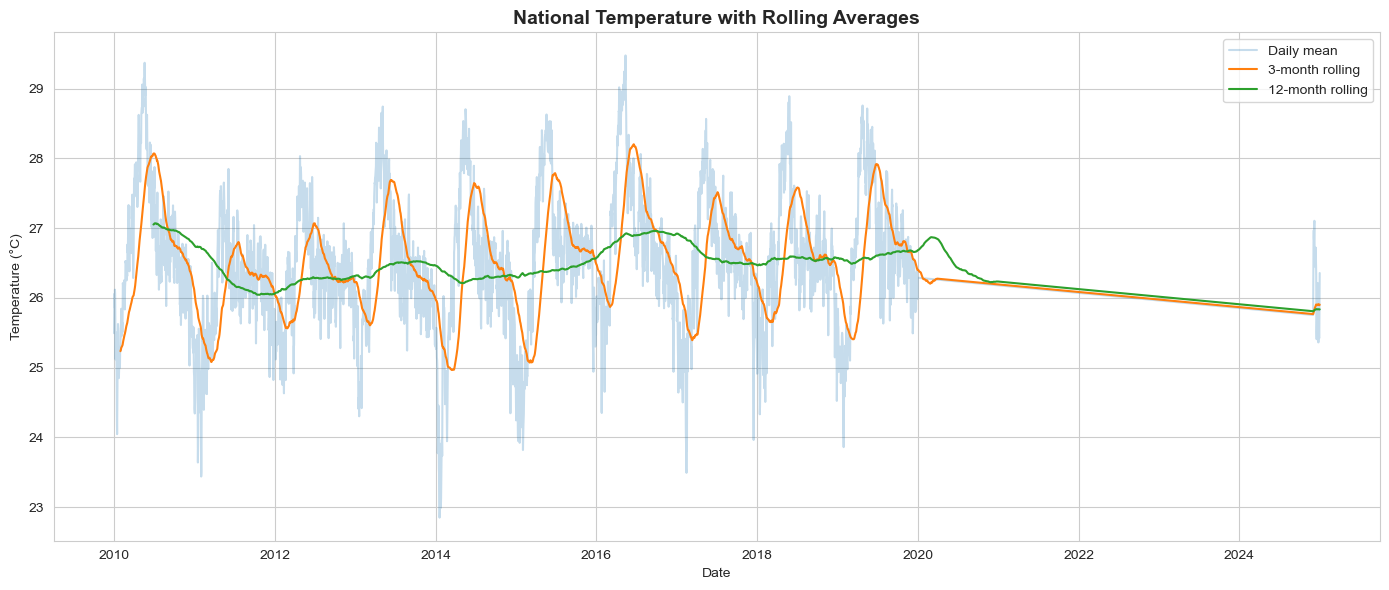

In [124]:
display(Markdown("## Rolling averages (3-month & 12-month) — National"))
rolling_df = national_daily.to_frame().rename(columns={'temperature_2m_mean':'daily_mean'})
rolling_df['3M'] = rolling_df['daily_mean'].rolling(window=90, min_periods=30).mean()
rolling_df['12M'] = rolling_df['daily_mean'].rolling(window=365, min_periods=180).mean()

plt.figure(figsize=(14,6))
plt.plot(rolling_df.index, rolling_df['daily_mean'], alpha=0.25, label='Daily mean')
plt.plot(rolling_df.index, rolling_df['3M'], label='3-month rolling')
plt.plot(rolling_df.index, rolling_df['12M'], label='12-month rolling')
plt.title("National Temperature with Rolling Averages", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()

## Seasonal Analysis — Monthly patterns
We show national monthly mean and monthly distribution per city (boxplots).

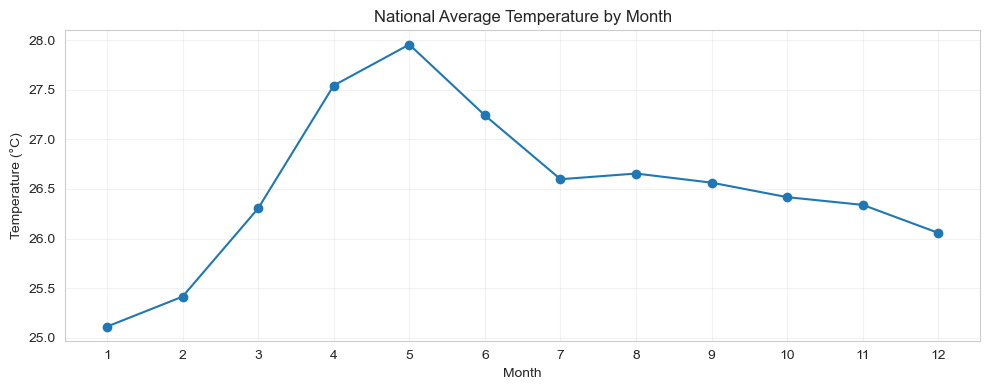

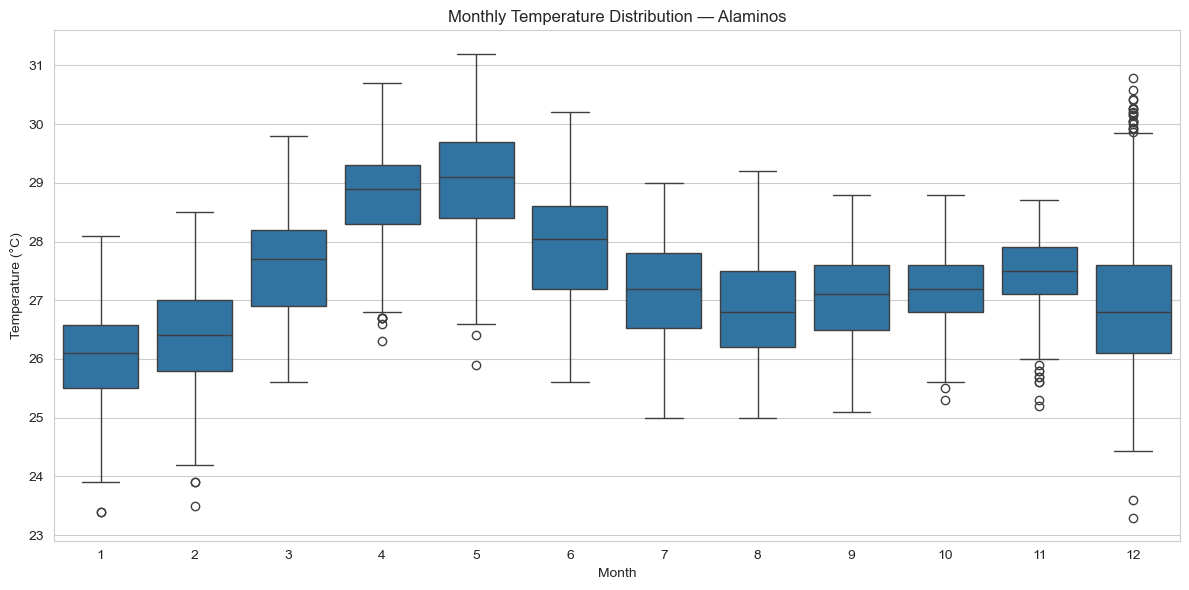

In [125]:
display(Markdown("## Seasonal Analysis — Monthly patterns\nWe show national monthly mean and monthly distribution per city (boxplots)."))

# National monthly mean
df['month'] = df['datetime'].dt.month
monthly_national = df.groupby('month')['temperature_2m_mean'].mean().reindex(range(1,13))
plt.figure(figsize=(10,4))
plt.plot(monthly_national.index, monthly_national.values, marker='o')
plt.xticks(range(1,13))
plt.title("National Average Temperature by Month")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# Monthly distribution per city (boxplots)
city = top_cities[0] if top_cities else df['city_name'].dropna().unique()[0]
plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='temperature_2m_mean', data=df[df['city_name']==city])
plt.title(f"Monthly Temperature Distribution — {city}")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.show()

In [126]:
display(Markdown("## Seasonal grouping (DJF, MAM, JJA, SON) — average per season"))
season_map = {12:'DJF',1:'DJF',2:'DJF', 3:'MAM',4:'MAM',5:'MAM', 6:'JJA',7:'JJA',8:'JJA', 9:'SON',10:'SON',11:'SON'}
df['season'] = df['month'].map(season_map)
seasonal = df.groupby('season')['temperature_2m_mean'].mean().reindex(['DJF','MAM','JJA','SON'])
display(seasonal.to_frame("mean_temp"))
display(Markdown("Interpretation: compare seasonal means to identify which season carries the highest average temperatures."))

## Seasonal grouping (DJF, MAM, JJA, SON) — average per season

,mean_temp
season,
DJF,25.686
MAM,27.266
JJA,26.828
SON,26.440


Interpretation: compare seasonal means to identify which season carries the highest average temperatures.

In [127]:
display(Markdown("## Temperature extremes — per city and per year"))

# Prepare year
df['year'] = df['datetime'].dt.year
extremes_city_year = df.groupby(['city_name','year']).agg(
    max_temp=('temperature_2m_max','max'),
    min_temp=('temperature_2m_min','min')
).reset_index()

# Show extremes for last 5 years available
recent_years = sorted(df['year'].dropna().unique())[-5:]
display(Markdown(f"Showing extremes for recent years: {recent_years}"))
display(extremes_city_year[extremes_city_year['year'].isin(recent_years)].sort_values(['city_name','year']).head(20))


## Temperature extremes — per city and per year

Showing extremes for recent years: [2016, 2017, 2018, 2019, 2024]

,city_name,year,max_temp,min_temp
6,Alaminos,2016,34.100,22.800
7,Alaminos,2017,37.600,20.200
8,Alaminos,2018,37.000,20.700
9,Alaminos,2019,36.900,21.100
10,Alaminos,2024,30.780,24.430
17,Angeles City,2016,35.900,18.300
18,Angeles City,2017,37.000,17.700
19,Angeles City,2018,37.000,20.100
20,Angeles City,2019,37.700,18.000
21,Angeles City,2024,32.250,22.250


### Highest recorded max temperature per city (overall)

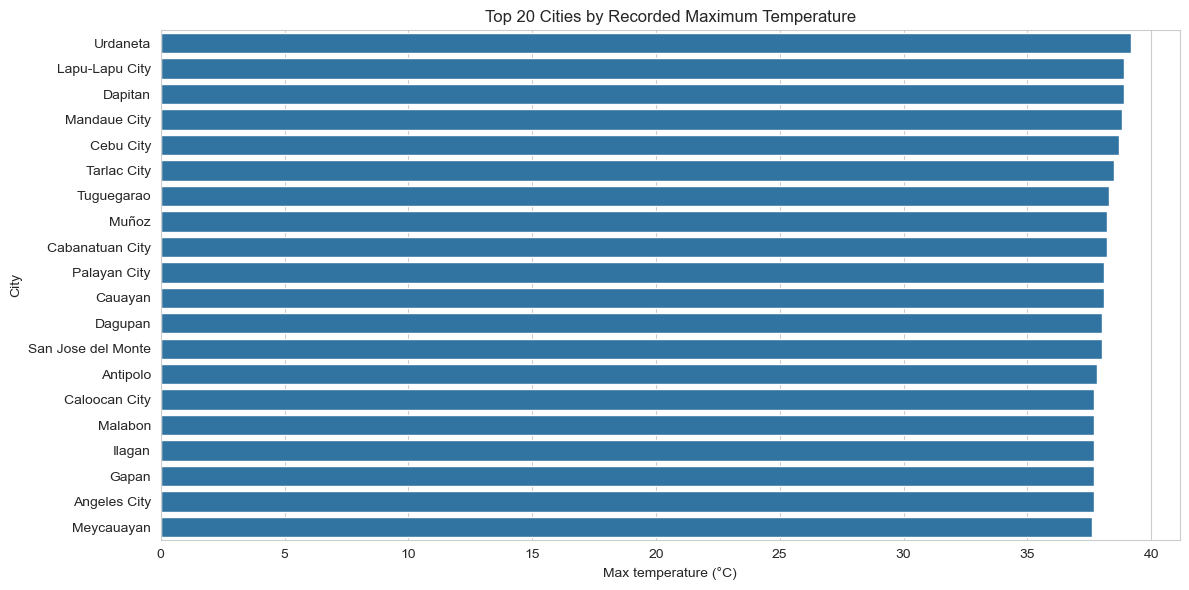

In [128]:
display(Markdown("### Highest recorded max temperature per city (overall)"))
city_max = df.groupby('city_name')['temperature_2m_max'].max().reset_index().dropna().sort_values('temperature_2m_max', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x='temperature_2m_max', y='city_name', data=city_max.head(20))
plt.xlabel("Max temperature (°C)")
plt.ylabel("City")
plt.title("Top 20 Cities by Recorded Maximum Temperature")
plt.tight_layout()
plt.show()

In [129]:
display(Markdown("## Detecting temperature anomalies (heatwaves/cold spells) — z-score method per city"))

# Per city daily mean and z-score
city_daily = df.set_index('datetime').groupby('city_name')['temperature_2m_mean'].resample('D').mean().reset_index()
city_daily['z'] = city_daily.groupby('city_name')['temperature_2m_mean'].transform(lambda x: stats.zscore(x, nan_policy='omit'))
# Mark anomalies
heatwaves = city_daily[city_daily['z'] > 2.5]  # high anomalies
cold_spells = city_daily[city_daily['z'] < -2.5]
display(Markdown(f"Detected {len(heatwaves)} heatwave-like days and {len(cold_spells)} cold-spell-like days across cities (z>|2.5|)."))
display(heatwaves.head())

## Detecting temperature anomalies (heatwaves/cold spells) — z-score method per city

Detected 4430 heatwave-like days and 3978 cold-spell-like days across cities (z>|2.5|).

,city_name,datetime,temperature_2m_mean,z
131,Alaminos,2010-05-12,30.500,2.639
135,Alaminos,2010-05-16,30.500,2.639
136,Alaminos,2010-05-17,30.600,2.723
137,Alaminos,2010-05-18,30.700,2.807
139,Alaminos,2010-05-20,30.400,2.555


## Correlation analysis — temperature variables

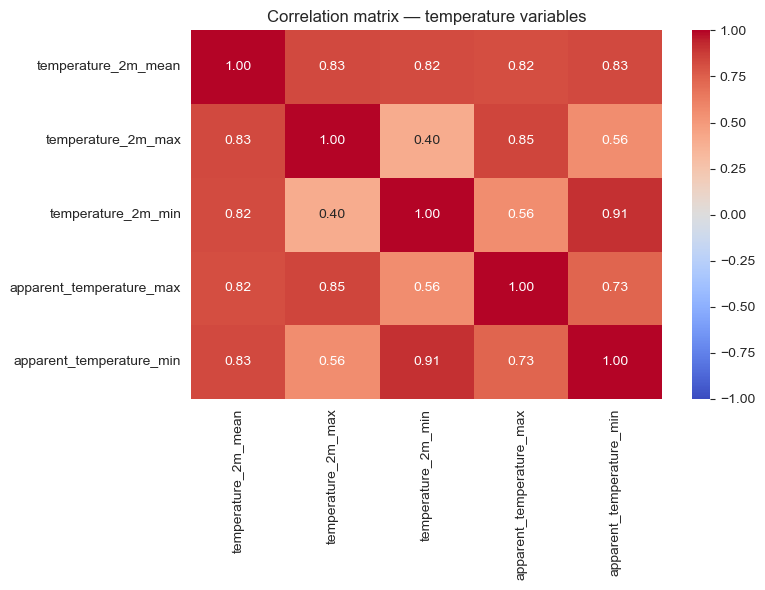

Interpretation: strong positive correlations between mean/max/min are expected. Apparent temperatures correlate depending on humidity and wind.

In [130]:
display(Markdown("## Correlation analysis — temperature variables"))

corr_vars = [c for c in ['temperature_2m_mean','temperature_2m_max','temperature_2m_min',
                         'apparent_temperature_max','apparent_temperature_min'] if c in df.columns]
corr = df[corr_vars].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation matrix — temperature variables")
plt.tight_layout()
plt.show()

display(Markdown("Interpretation: strong positive correlations between mean/max/min are expected. Apparent temperatures correlate depending on humidity and wind."))

In [133]:
display(Markdown("## Geospatial visualization — average temperature per city"))

geo_cols = ['latitude','longitude']
if all(c in df.columns for c in geo_cols):
    city_geo = df.groupby(['city_name','latitude','longitude'])['temperature_2m_mean'].mean().reset_index().dropna()
    plt.figure(figsize=(10,8))
    sc = plt.scatter(city_geo['longitude'], city_geo['latitude'], c=city_geo['temperature_2m_mean'], s=(city_geo['temperature_2m_mean']-city_geo['temperature_2m_mean'].min()+1)*8, cmap='hot', alpha=0.8)
    plt.colorbar(sc, label='Avg Temperature (°C)')
    plt.title("Average Temperature per City (Longitude vs Latitude)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    for _, r in city_geo.sample(min(10, len(city_geo))).iterrows():
        plt.text(r['longitude'], r['latitude'], r['city_name'], fontsize=8)
    plt.tight_layout()
    plt.show()

    if PLOTLY_AVAILABLE:
        fig = px.scatter_mapbox(city_geo, lat="latitude", lon="longitude", hover_name="city_name",
                                color="temperature_2m_mean", size="temperature_2m_mean",
                                color_continuous_scale="thermal", zoom=5, size_max=18)
        fig.update_layout(mapbox_style="open-street-map")
        fig.update_layout(title="Interactive: Average Temperature per City")
        fig.show()
else:
    display(Markdown("Latitude/Longitude columns not found — skipping geospatial visualization."))

## Geospatial visualization — average temperature per city

Latitude/Longitude columns not found — skipping geospatial visualization.

## Apparent vs Actual Temperature — national average comparison

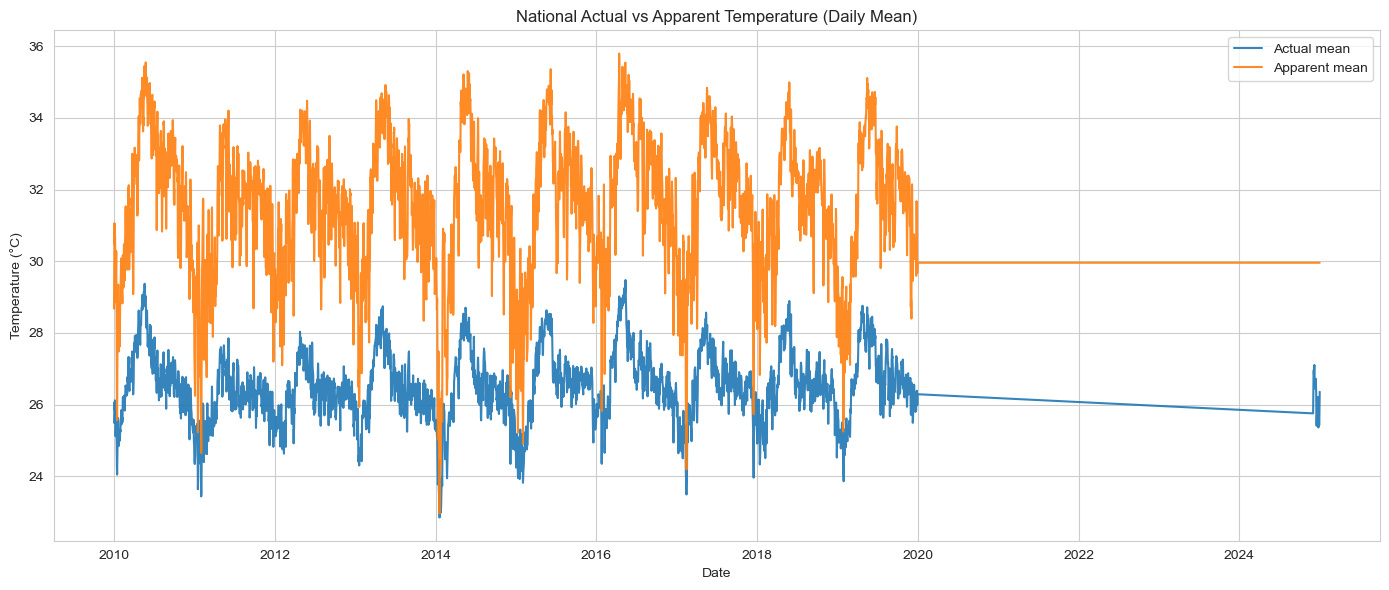

In [ ]:
display(Markdown("## Apparent vs Actual Temperature — National Average Comparison"))

# Ensure datetime column is datetime type
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.dropna(subset=['datetime'])

# Detect and construct apparent temperature mean if missing
if 'apparent_temperature_mean' not in df.columns:
    if {'apparent_temperature_max', 'apparent_temperature_min'}.issubset(df.columns):
        df['apparent_temperature_mean'] = (
            pd.to_numeric(df['apparent_temperature_max'], errors='coerce') + 
            pd.to_numeric(df['apparent_temperature_min'], errors='coerce')
        ) / 2

# Determine available apparent temperature column
app_col = None
for col in ['apparent_temperature_mean', 'apparent_temperature_max', 'apparent_temperature_min']:
    if col in df.columns:
        app_col = col
        break

# Proceed only if both actual and apparent temperatures are available
if app_col and 'temperature_2m_mean' in df.columns:
    # Convert to numeric and clean
    df['temperature_2m_mean'] = pd.to_numeric(df['temperature_2m_mean'], errors='coerce')
    df[app_col] = pd.to_numeric(df[app_col], errors='coerce')

    # Resample and interpolate
    nat_actual = df.set_index('datetime')['temperature_2m_mean'].resample('D').mean().interpolate('time')
    nat_apparent = df.set_index('datetime')[app_col].resample('D').mean().interpolate('time')

    # Drop empty or invalid series
    if nat_actual.dropna().empty or nat_apparent.dropna().empty:
        display(Markdown("⚠️ No valid temperature data available for comparison."))
    else:
        plt.figure(figsize=(14,6))
        plt.plot(nat_actual.index, nat_actual.values, label='Actual Mean Temperature', color='red', alpha=0.8)
        plt.plot(nat_apparent.index, nat_apparent.values, label='Apparent Mean Temperature', color='orange', alpha=0.8)
        plt.title("National Actual vs Apparent Temperature (Daily Mean)", fontsize=16)
        plt.xlabel("Date", fontsize=14)
        plt.ylabel("Temperature (°C)", fontsize=14)
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    display(Markdown("⚠️ Apparent temperature columns not found — skipping comparison."))

In [135]:
display(Markdown("## Optional: Inspect top anomalous heat days per city"))
top_heat = heatwaves.sort_values(['city_name','z'], ascending=[True, False]).groupby('city_name').head(3)
display(top_heat[['city_name','datetime','temperature_2m_mean','z']].head(30))
display(Markdown("Investigate reported events on these dates (local news / station logs) for validation."))

## Optional: Inspect top anomalous heat days per city

,city_name,datetime,temperature_2m_mean,z
2688,Alaminos,2017-05-12,31.200,3.226
2687,Alaminos,2017-05-11,31.100,3.142
2318,Alaminos,2016-05-07,31.000,3.058
5617,Angeles City,2010-05-19,31.300,3.145
5616,Angeles City,2010-05-18,31.200,3.082
7076,Angeles City,2014-05-17,31.100,3.019
14027,Antipolo,2018-05-28,31.300,3.425
14018,Antipolo,2018-05-19,31.100,3.294
14026,Antipolo,2018-05-27,31.000,3.229
18761,Bacolod,2016-05-13,30.400,3.188


Investigate reported events on these dates (local news / station logs) for validation.

In [136]:
display(Markdown("## Save artifacts — summary per city"))
artifact_path = "data/processed/phil_temp_city_summary.csv"
city_summary = df.groupby('city_name')['temperature_2m_mean'].agg(['count','mean','min','max','std']).reset_index()
os.makedirs(os.path.dirname(artifact_path), exist_ok=True)
city_summary.to_csv(artifact_path, index=False)
display(Markdown(f"Saved city summary to `{artifact_path}` ({city_summary.shape[0]} rows)."))
city_summary.head()

## Save artifacts — summary per city

Saved city summary to `data/processed/phil_temp_city_summary.csv` (138 rows).

,city_name,count,mean,min,max,std
0,Alaminos,4028,27.328,23.300,31.200,1.228
1,Angeles City,4028,26.382,21.200,32.250,1.690
2,Antipolo,4028,25.942,20.720,32.370,1.706
3,Bacolod,4028,26.998,22.660,30.540,1.145
4,Bacoor,4028,27.805,22.400,32.500,1.493


In [137]:
display(Markdown("## Final notes & next steps\n"
                 "- This EDA is reproducible: re-run after ingesting new data to refresh visuals.\n"
                 "- Next steps: time-series decomposition, trend+seasonality statistical tests, "
                 "and ML-ready feature engineering (lags, rolling stats, categorical seasons).\n"
                 "- If you want, I can export this notebook to `.ipynb` JSON for direct download."))

## Final notes & next steps
- This EDA is reproducible: re-run after ingesting new data to refresh visuals.
- Next steps: time-series decomposition, trend+seasonality statistical tests, and ML-ready feature engineering (lags, rolling stats, categorical seasons).
- If you want, I can export this notebook to `.ipynb` JSON for direct download.